# various operation for image

### mean

In [6]:
import os
from nilearn.image import mean_img

img1 = r'/mnt/workdir/DCM/tmp/2022.4.11/Park_ROI_align_result/test_set/EC/testset1/group_6fold/hp/2ndLevel/_contrast_id_ZT_0001/con_0001.nii'
img2 = r'/mnt/workdir/DCM/tmp/2022.4.11/Park_ROI_align_result/test_set/EC/testset2/group_6fold/hp/2ndLevel/_contrast_id_ZT_0001/con_0001.nii'
new_img = mean_img([img1,img2])

savedir = r'/mnt/workdir/DCM/tmp/2022.4.11/Park_ROI_align_result/test_set/EC/6fold/hp'
if not os.path.exists(savedir):
    os.makedirs(savedir)

savepath = os.path.join(savedir,'mean_betas_align_EC_Phi.nii')
new_img.to_filename(savepath)

In [3]:
import os
import pandas as pd
from nilearn.image import load_img,mean_img
from nilearn.glm.second_level import SecondLevelModel
cmaps = []
cmap_dir1 = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/alignPhi/EC_park/Set1/6fold'
cmap_dir2 = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/alignPhi/EC_park/Set2/6fold'
#
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv,sep='\t')
data = participants_data.query('game1_fmri==1')  # look out
data = data.query('game1_acc>=0.80')
pid = data['Participant_ID'].to_list()
subjects = [p.replace('_','-') for p in pid]

for sub in subjects:
    img1 = load_img(os.path.join(cmap_dir1,sub,'ZT_0003.nii'))
    img2 = load_img(os.path.join(cmap_dir2,sub,'ZT_0003.nii'))
    mimg = mean_img([img1,img2])
    cmaps.append(mimg)

design_matrix = pd.DataFrame([1] * len(cmaps), columns=['intercept'])

second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(cmaps, design_matrix=design_matrix)
import os
out_img = second_level_model.compute_contrast(second_level_stat_type='t',output_type='all')
savedir = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/alignPhi/EC_park/group/6fold/hp/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

cmap = out_img['effect_size']
tmap = out_img['stat']
zmap = out_img['z_score']
pmap = out_img['p_value']

cmap.to_filename(os.path.join(savedir,'cmap_align_EC_park_Phi.nii'))
tmap.to_filename(os.path.join(savedir,'tmap_align_EC_park_Phi.nii'))
zmap.to_filename(os.path.join(savedir,'zmap_align_EC_park_Phi.nii'))
pmap.to_filename(os.path.join(savedir,'pmap_align_EC_park_Phi.nii'))


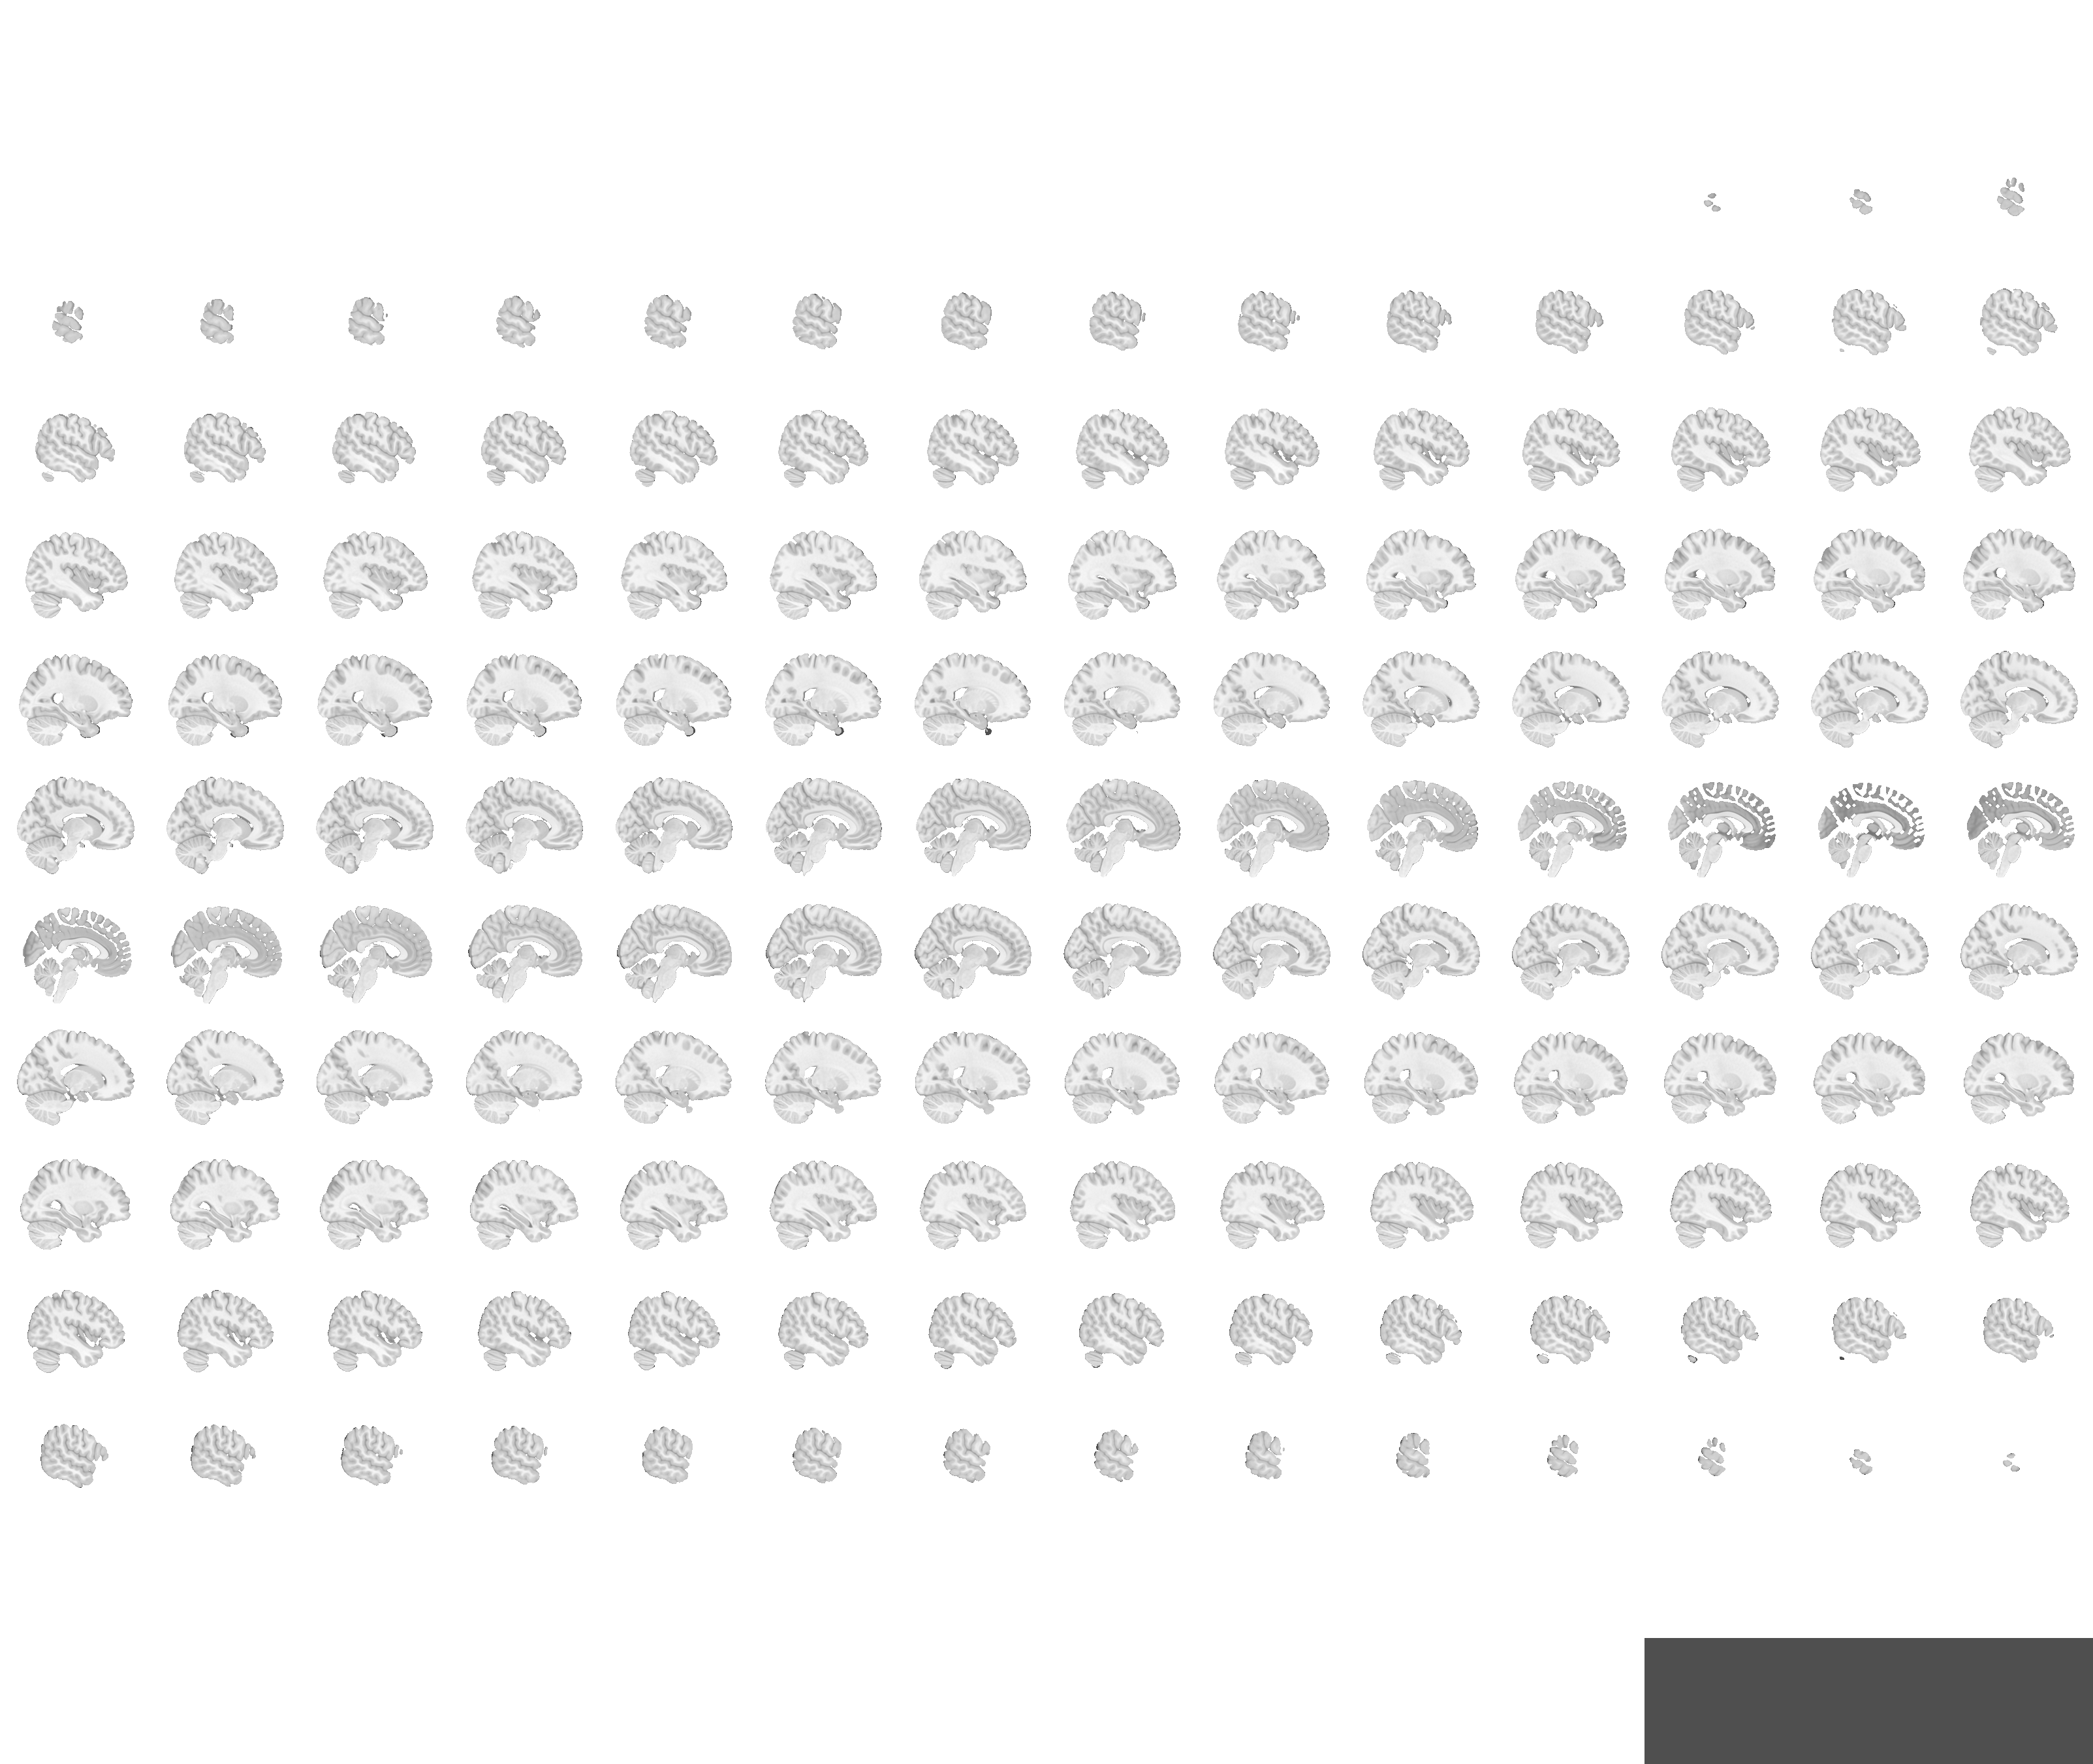
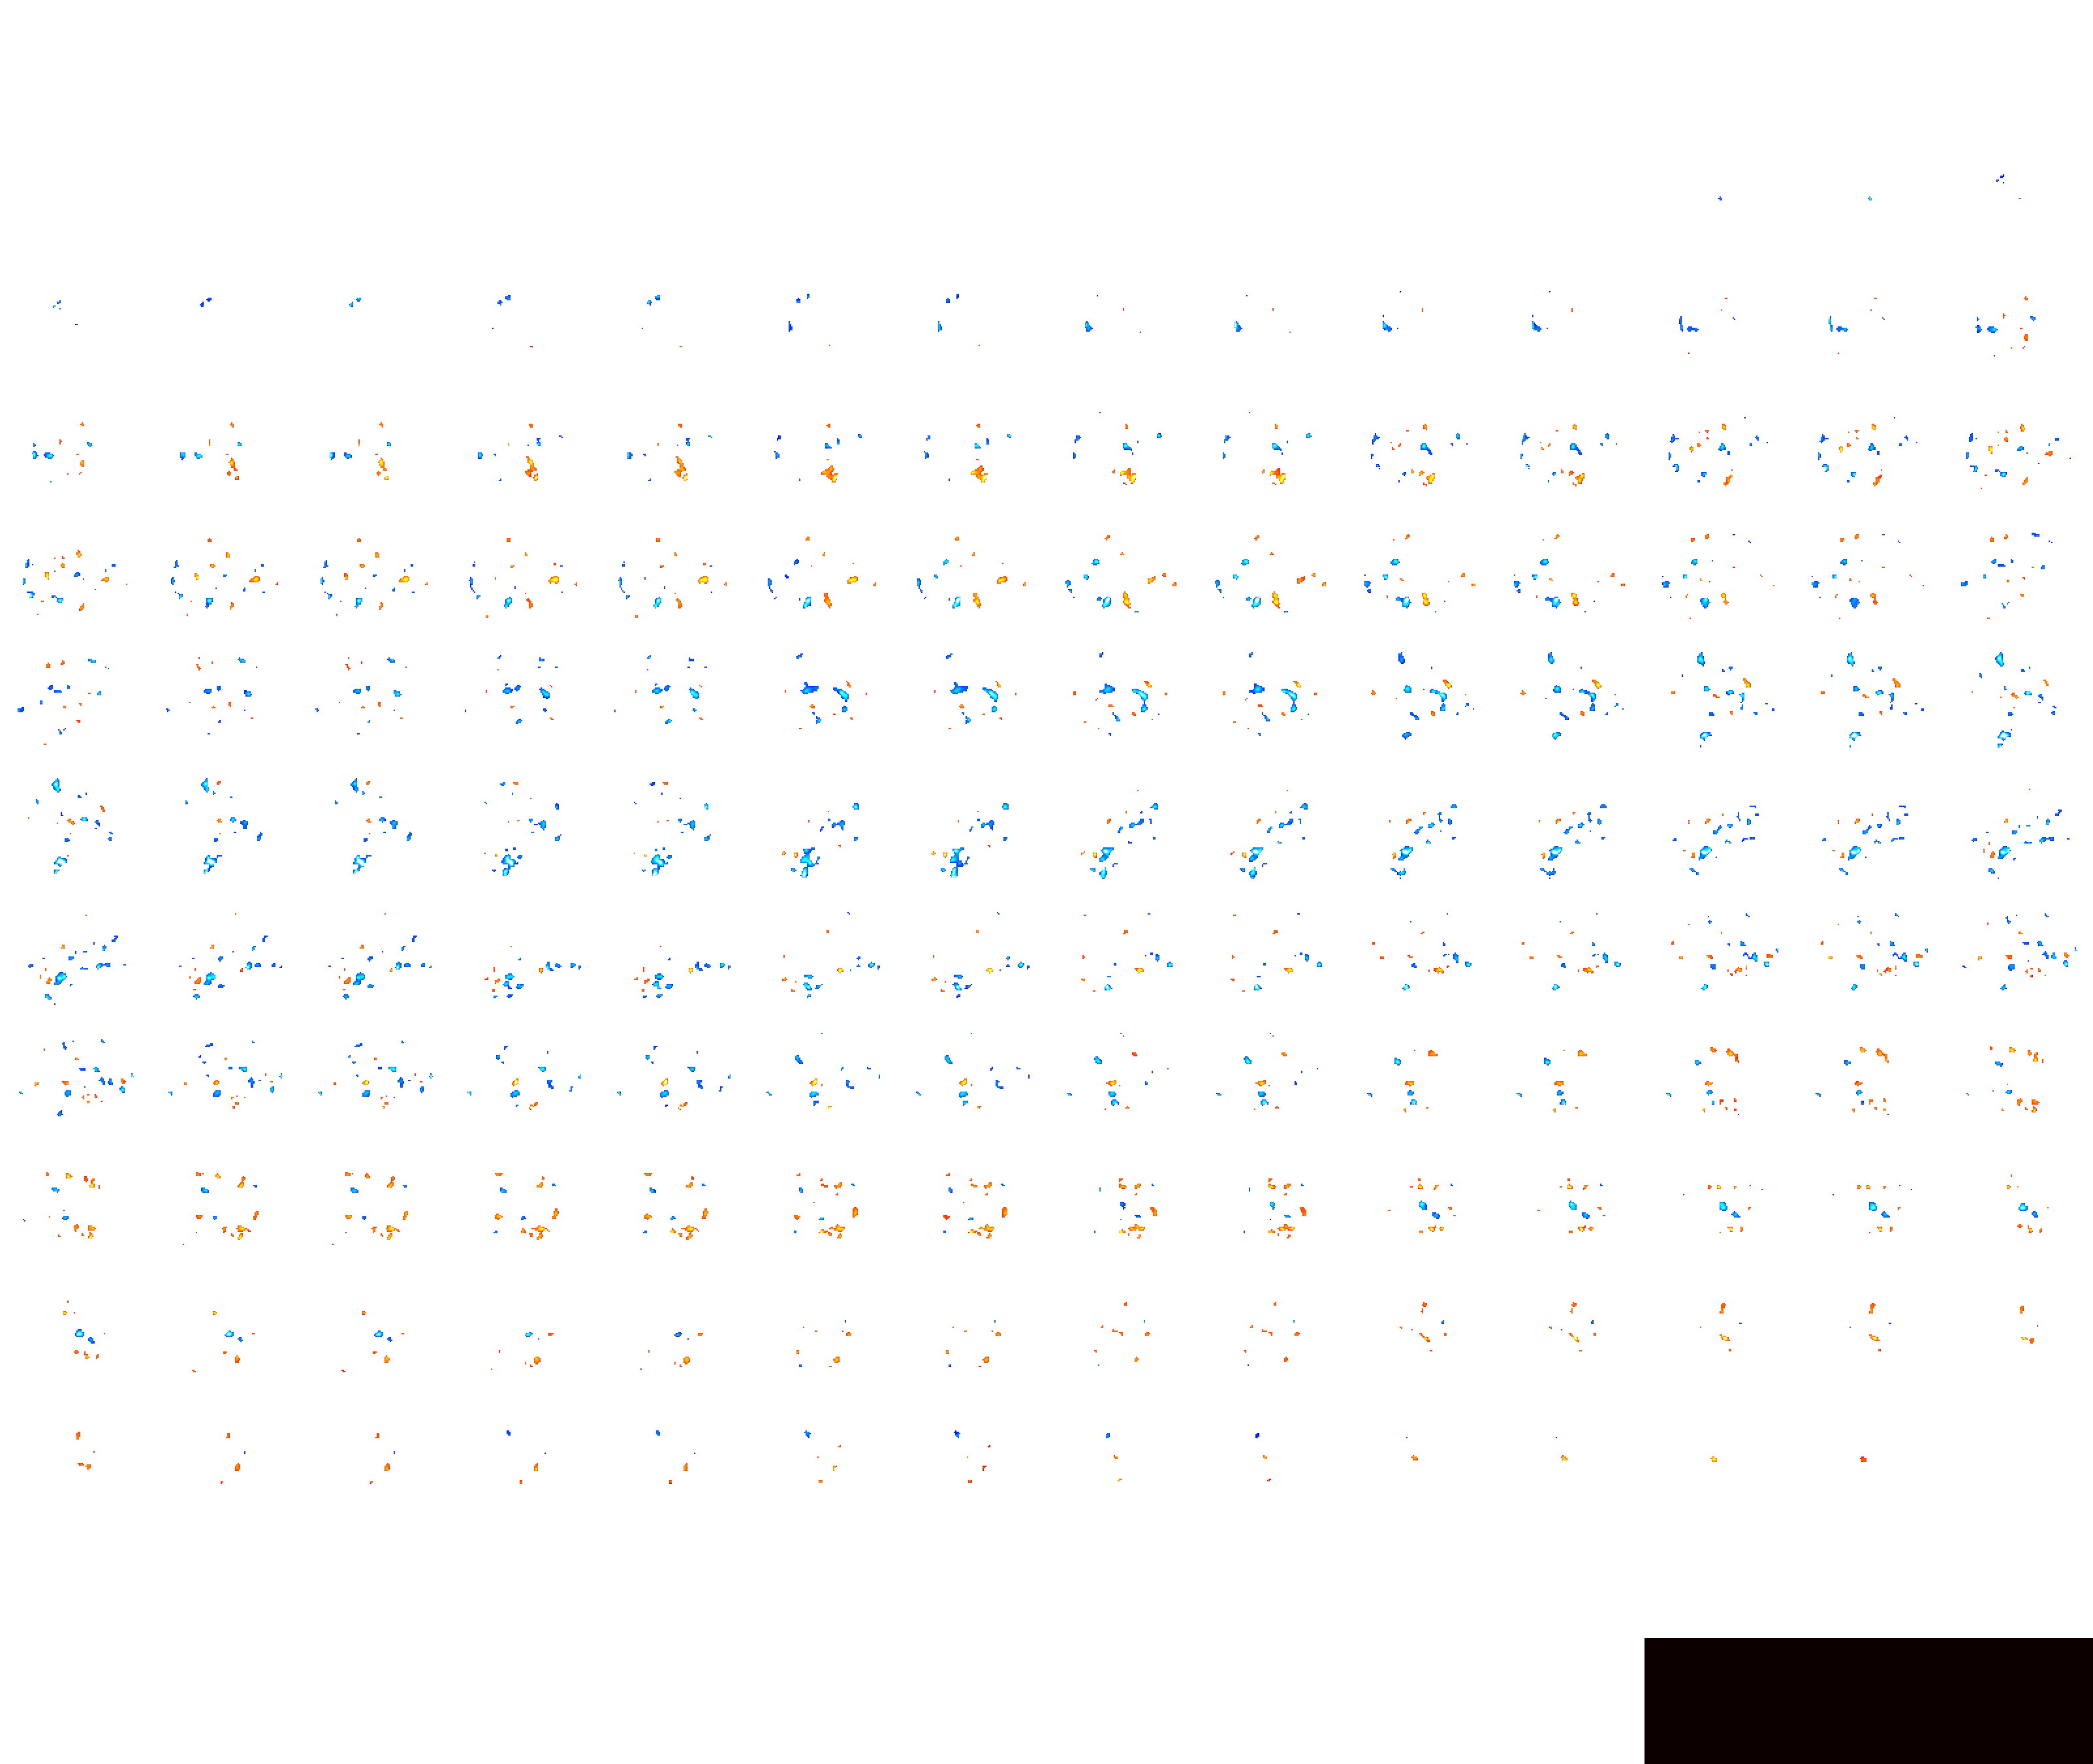

In [2]:
from nilearn.plotting import plot_stat_map,view_img
from nilearn.image import load_img
import matplotlib.pyplot as plt

stat_map = load_img(os.path.join(savedir,'tmap_align_EC_func_Phi.nii'))
bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')
view_img(stat_map_img=stat_map,bg_img=bg_img,threshold=2.3,vmax=5,symmetric_cbar=0,black_bg=None)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dell/Software/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dell/Software/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

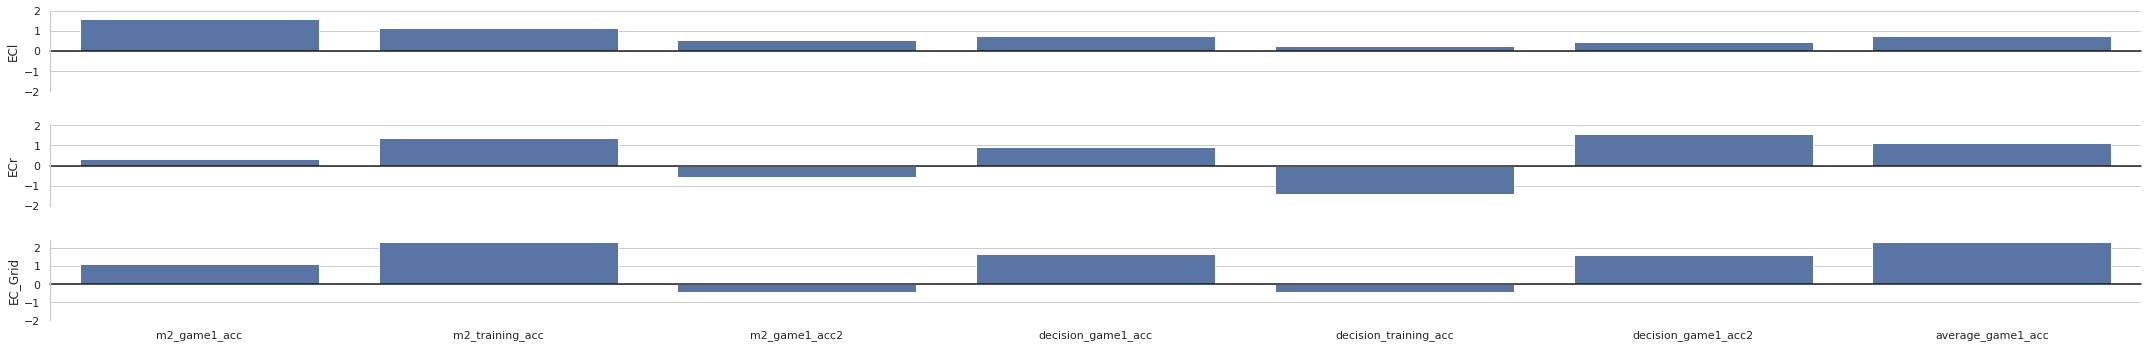

In [1]:
# find the rois whose hexagonal modulation have maximum association with accuracy
from nilearn.masking import apply_mask
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

rois = ['ECl','ECr','EC_Grid']
roi_template = r'/mnt/workdir/DCM/docs/Reference/Park_Grid_ROI/{}_roi.nii'


cmap_dict = {'m2_game1_acc':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/acc/2ndLevel/_contrast_id_ZF_0005/spmT_0002.nii',
            'm2_training_acc':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/training_acc&game1_acc/2ndLevel/_contrast_id_ZF_0005/spmT_0002.nii',
            'm2_game1_acc2':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/training_acc&game1_acc/2ndLevel/_contrast_id_ZF_0005/spmT_0003.nii',
            'decision_game1_acc':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/acc/2ndLevel/_contrast_id_ZF_0006/spmT_0002.nii',
            'decision_training_acc':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/training_acc&game1_acc/2ndLevel/_contrast_id_ZF_0006/spmT_0002.nii',
            'decision_game1_acc2':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/training_acc&game1_acc/2ndLevel/_contrast_id_ZF_0006/spmT_0003.nii',
             'average_game1_acc':r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/acc/2ndLevel/_contrast_id_ZF_0011/spmT_0002.nii'
            }

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,5),sharex=True)
for roi_name,ax in zip(rois,(ax1, ax2, ax3)):
    roi_path = roi_template.format(roi_name)
    mean_activitys = []
    names = []
    for name,path in cmap_dict.items():
        mean_activitys.append(apply_mask(path,roi_path).mean())
        names.append(name)

    sns.barplot(names,mean_activitys,color='b',ax=ax)
    ax.axhline(0, color="k", clip_on=False)
    ax.set_ylabel(roi_name)

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[-2,-1,0,1,2])
plt.tight_layout(h_pad=2)